In [43]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder 

import numpy as np

In [44]:
games = pd.read_csv("games.csv")
games.count()
cleaned_games = games.drop(['id', 'white_id', 'black_id', 'moves','created_at','last_move_at'], axis=1)
labelencoder = LabelEncoder()
cleaned_games['winner'] = labelencoder.fit_transform(cleaned_games['winner'])
cleaned_games['rated'] = labelencoder.fit_transform(cleaned_games['rated'])
cleaned_games['victory_status'] = labelencoder.fit_transform(cleaned_games['victory_status'])
cleaned_games['increment_code'] = labelencoder.fit_transform(cleaned_games['increment_code'])
cleaned_games['opening_eco'] = labelencoder.fit_transform(cleaned_games['opening_eco'])
cleaned_games['opening_name'] = labelencoder.fit_transform(cleaned_games['opening_name'])
cleaned_games
X = cleaned_games.drop('winner', axis=1)
y = cleaned_games['winner']
y = y.values
y = y.astype(int)

In [45]:
X = preprocessing.scale(X)
img_path = 'images_chess/'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

## Decision Tree

Accuracy of decision tree classifier without hyperparameter tuning is 62.49%
Best parameters:
{'max_depth': 9, 'min_samples_split': 2}
Accuracy of decision tree classifier is 65.44%


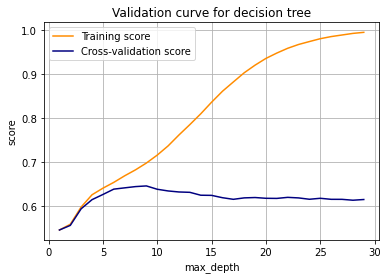

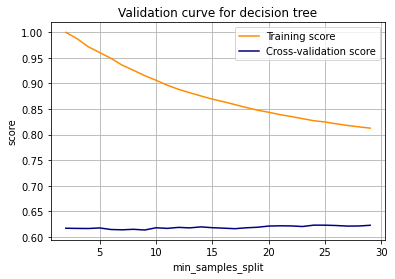

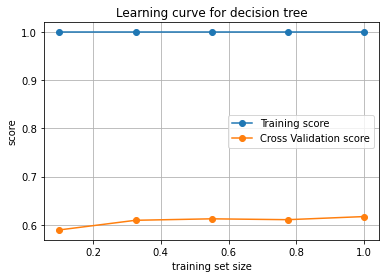

In [25]:
dt_classifer = tree.DecisionTreeClassifier(random_state=7)
dt_classifer.fit(X_train, y_train)
prediction_y = dt_classifer.predict(X_test)
dt_accuracy = accuracy_score(y_test, prediction_y)
print('Accuracy of decision tree classifier without hyperparameter tuning is %.2f%%' % (dt_accuracy * 100))

param_range = np.arange(1, 30)
train_scores, test_scores = validation_curve(tree.DecisionTreeClassifier(random_state=7), X_train, y_train,
                                             param_name="max_depth", param_range=param_range, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure()
plt.title('Validation curve for decision tree')
plt.plot(param_range,train_scores_mean, label='Training score',color="darkorange")
plt.plot(param_range, test_scores_mean, label='Cross-validation score',color="navy")
plt.xlabel('max_depth')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'dt_validation_curve_graph_1.png')

param_range_2 = np.arange(2, 30)
train_scores, test_scores = validation_curve(tree.DecisionTreeClassifier(random_state=7), X_train, y_train,
                                             param_name="min_samples_split", param_range=param_range_2, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(param_range_2, train_scores_mean, label='Training score',color="darkorange")
plt.plot(param_range_2, test_scores_mean, label='Cross-validation score',color="navy")
plt.title('Validation curve for decision tree')
plt.xlabel('min_samples_split')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'dt_validation_curve_graph_2.png')

parameters = {'max_depth': param_range, 'min_samples_split': param_range_2}
best_dt_classifer = GridSearchCV(dt_classifer, param_grid=parameters, cv=5)
best_dt_classifer.fit(X_train, y_train)
print("Best parameters:")
print(best_dt_classifer.best_params_)
prediction_y = best_dt_classifer.predict(X_test)
dt_accuracy = accuracy_score(y_test, prediction_y)
print('Accuracy of decision tree classifier is %.2f%%' % (dt_accuracy * 100))

_, train_scores, test_scores = learning_curve(dt_classifer, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(np.linspace(0.1, 1.0, 5), train_scores_mean, 'o-', label='Training score')
plt.plot(np.linspace(0.1, 1.0, 5), test_scores_mean, 'o-', label='Cross Validation score')
plt.title('Learning curve for decision tree')
plt.xlabel('training set size')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'dt_learning_curve_graph.png')


In [ ]:
# visualization of decision tree
clf =  tree.DecisionTreeClassifier(random_state=3, criterion='entropy', max_depth=9)
clf = clf.fit(X_train, y_train)
features = list(X_train.columns.values)
dot_data = tree.export_graphviz(clf, out_file=None, 
                        feature_names=features,  
                        class_names=list(map(str, set(y))),  
                        filled=True, rounded=True,  
                        special_characters=True)
graph = graphviz.Source(dot_data)
graph

# Boosting

Accuracy of Adaboost without hyperparameter tuning is 50.37%
Best parameters:
{'learning_rate': 0.1, 'n_estimators': 100}
Accuracy of decision tree is 58.33%


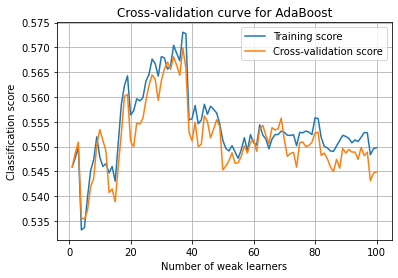

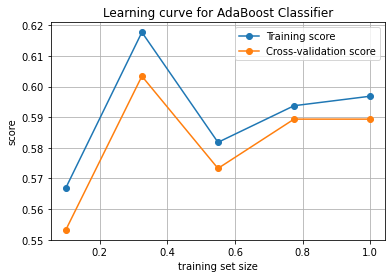

In [46]:
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=100,random_state=7)
clf_boosted.fit(X_train, y_train)
y_pred = clf_boosted.predict(X_test)
boosted_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Adaboost without hyperparameter tuning is %.2f%%' % (boosted_accuracy * 100))

num_folds = 5
kf = KFold(n_splits=num_folds,shuffle=False, random_state=None)
train_scores = np.zeros((100, num_folds))
val_scores = np.zeros((100, num_folds))
for idx, (train_index, test_index) in enumerate(kf.split(X_train)):
    clf_boosted.fit(X_train[train_index], y_train[train_index])
    train_scores[:, idx] = np.asarray(list(clf_boosted.staged_score(X_train[train_index], y_train[train_index])))
    val_scores[:, idx] = np.asarray(list(clf_boosted.staged_score(X_train[test_index], y_train[test_index])))

n_estimators_range = np.arange(100) + 1
plt.figure()
plt.plot(n_estimators_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(n_estimators_range, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.title('Cross-validation curve for AdaBoost')
plt.xlabel('Number of weak learners')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'boost_validation_curve.png')


parameters = {
    "n_estimators": [5, 10, 15, 20, 25, 50, 75, 100],
    "learning_rate": [0.001, 0.01, 0.1, 1.],
}


clf = GridSearchCV(
    clf_boosted,
    parameters,
    cv=5,
    scoring='accuracy',
)

clf.fit(X_train, y_train)
print("Best parameters:")
print(clf.best_params_)
y_pred = clf.best_estimator_.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of decision tree is %.2f%%' % (dt_accuracy * 100))


_, train_scores, test_scores = learning_curve(clf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5)
mean_train_scores = np.mean(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)

plt.figure()
plt.title('Learning curve for AdaBoost Classifier')

plt.plot(np.linspace(0.1, 1.0, 5), mean_train_scores, 'o-', label='Training score')
plt.plot(np.linspace(0.1, 1.0, 5), mean_test_scores, 'o-', label='Cross-validation score')
plt.xlabel('training set size')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'boost_learning_curve.png')

# Neural Networks

Accuracy of neural network MLP Classifier is 66.90%
Best parameters:
{'alpha': 0.31622776601683794, 'learning_rate_init': 0.01}


'\n#Loss Curve\n\nmlp_classifier = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=7, max_iter=1, warm_start=True)\nmlp_classifier.set_params(alpha=best_parameters[\'alpha\'], learning_rate_init=best_parameters[\'learning_rate_init\'])\n\nX_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train, y_train, test_size=0.2, random_state=12)\n\nnum_epochs = 500\ntraining_loss = np.empty(num_epochs)\ntraining_scores = np.empty(num_epochs)\nscores = np.empty(num_epochs)\nfor i in range(num_epochs):\n    mlp_classifier.fit(X_train_new, y_train_new)\n    training_loss[i] = mlp_classifier.loss_\n    training_scores[i] = accuracy_score(y_train, mlp_classifier.predict(X_train_new))\n    scores[i] = accuracy_score(y_test_new, mlp_classifier.predict(X_test_new))\n\nprediction_y = mlp_classifier.predict(X_test)\nnn_accuracy = accuracy_score(y_test, prediction_y)\nprint(\'Accuracy of neural network MLP Classifier is %.2f%%\' % (nn_accuracy * 100))\n\nxrange = np.arange(num_epoc

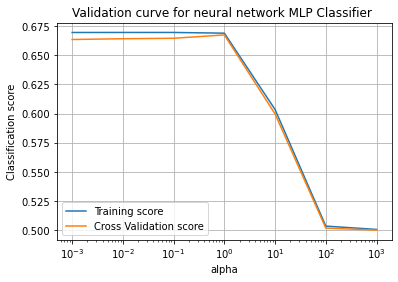

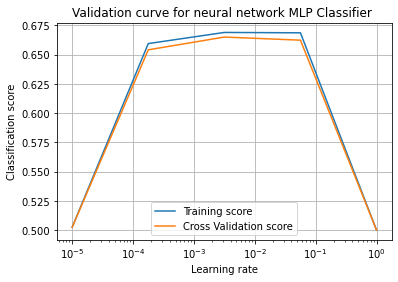

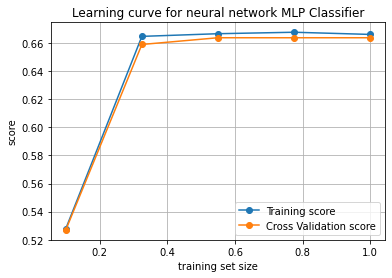

In [35]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=7, early_stopping=True, max_iter=300,validation_fraction=0.2)
mlp_classifier.fit(X_train, y_train)
prediction_y = mlp_classifier.predict(X_test)
nn_accuracy = accuracy_score(y_test, prediction_y)
print('Accuracy of neural network MLP Classifier is %.2f%%' % (nn_accuracy * 100))

train_scores, test_scores = validation_curve(mlp_classifier, X_train, y_train, param_name="alpha", param_range=np.logspace(-3, 3, 7), cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure()
plt.title('Validation curve for neural network MLP Classifier ')
plt.semilogx(np.logspace(-3, 3, 7), train_scores_mean, label='Training score')
plt.semilogx(np.logspace(-3, 3, 7), test_scores_mean, label='Cross Validation score')
plt.xlabel('alpha')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'nn_validation_curve_1.png')

lr_range = np.logspace(-5, 0, 5)
train_scores, test_scores = validation_curve(mlp_classifier, X_train, y_train, param_name="learning_rate_init", param_range=np.logspace(-5, 0, 5),
                                             cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure()
plt.title('Validation curve for neural network MLP Classifier ')
plt.semilogx(np.logspace(-5, 0, 5), train_scores_mean, label='Training score')
plt.semilogx(np.logspace(-5, 0, 5), test_scores_mean, label='Cross Validation score')
plt.xlabel('Learning rate')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'nn_validation_curve_2.png')



# Define grid for grid search after observing validation curves
alpha_range = np.logspace(-3, 2, 5)
lr_range = np.logspace(-5, 0, 6)
tuned_params = {'alpha' : alpha_range, 'learning_rate_init' : lr_range}
best_mlp_classifier = GridSearchCV(mlp_classifier, param_grid=tuned_params, cv=5)
best_mlp_classifier.fit(X_train, y_train)
best_parameters = best_mlp_classifier.best_params_
print("Best parameters:")
print(best_parameters)


_, train_scores, test_scores = learning_curve(mlp_classifier, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure()
plt.title('Learning curve for neural network MLP Classifier')
plt.plot(np.linspace(0.1, 1.0, 5), train_scores_mean, 'o-', label='Training score')
plt.plot(np.linspace(0.1, 1.0, 5), test_scores_mean, 'o-', label='Cross Validation score')
plt.xlabel('training set size')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'nn_learning_curve.png')


# SVM

Accuracy of SVM Classifier with polynomial kernel is 65.84%
Accuracy of SVM Classifier with linear kernel is 66.60%
Accuracy of SVM Classifier with RBF kernel is 66.56%


KeyboardInterrupt: 

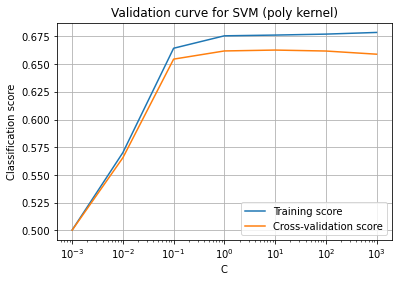

In [42]:
svm_classifier_poly = svm.SVC(kernel='poly')
svm_classifier_poly.fit(X_train, y_train)
prediction_y = svm_classifier_poly.predict(X_test)
svm_poly_accuracy = accuracy_score(y_test, prediction_y)
print('Accuracy of SVM Classifier with polynomial kernel is %.2f%%' % (svm_poly_accuracy * 100))


svm_classifier_linear = svm.SVC(kernel='linear')
svm_classifier_linear.fit(X_train, y_train)
prediction_y = svm_classifier_linear.predict(X_test)
svm_linear_accuracy = accuracy_score(y_test, prediction_y)
print('Accuracy of SVM Classifier with linear kernel is %.2f%%' % (svm_linear_accuracy * 100))


svm_classifier_rbf = svm.SVC(kernel='rbf')
svm_classifier_rbf.fit(X_train, y_train)
prediction_y = svm_classifier_rbf.predict(X_test)
svm_rbf_accuracy = accuracy_score(y_test, prediction_y)
print('Accuracy of SVM Classifier with RBF kernel is %.2f%%' % (svm_rbf_accuracy * 100))


train_scores, test_scores = validation_curve(svm_classifier_poly, X_train, y_train, param_name="C", param_range=np.logspace(-3, 3, 7), cv=5)

plt.figure()
plt.title('Validation curve for SVM (poly kernel)')

plt.semilogx(np.logspace(-3, 3, 7), np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(np.logspace(-3, 3, 7), np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('C')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'SVM_validation_curve_1.png')

tuned_params = {'C' : np.logspace(-3, 1, 10)}
best_svm_classifier = GridSearchCV(svm_classifier_poly, param_grid=tuned_params, cv=5)
best_svm_classifier.fit(X_train, y_train)
best_parameters = best_svm_classifier.best_params_
print("Best parameters :" )
print(best_parameters)
y_pred = best_svm_classifier.predict(X_test)
accuracy_score = accuracy_score(y_test, y_pred)
print('Best accuracy with SVM Classifier (poly kernel) is %.2f%%' % (accuracy_score * 100))




_, train_scores, test_scores = learning_curve(best_svm_classifier, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5)
mean_train_scores = np.mean(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(np.linspace(0.1, 1.0, 5), mean_train_scores, 'o-', label='Training score')
plt.plot(np.linspace(0.1, 1.0, 5), mean_test_scores, 'o-', label='Cross Validation score')
plt.title('Learning curve  SVM (Linear kernel)')
plt.xlabel('training set size')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'svm_learning_curve.png')


# KNN

Accuracy of KNN Classifier with k value = 1 is 60.36%
Accuracy of KNN Classifier with k value = 2 is 58.25%
Accuracy of KNN Classifier with k value = 3 is 60.66%
Accuracy of KNN Classifier with k value = 4 is 58.76%
Accuracy of KNN Classifier with k value = 5 is 59.92%
Accuracy of KNN Classifier with k value = 6 is 58.88%
Accuracy of KNN Classifier with k value = 7 is 59.84%
Accuracy of KNN Classifier with k value = 8 is 59.74%
Accuracy of KNN Classifier with k value = 9 is 60.58%
Accuracy of KNN Classifier with k value = 10 is 60.52%
Accuracy of KNN Classifier with k value = 11 is 60.80%
Accuracy of KNN Classifier with k value = 12 is 60.74%
Accuracy of KNN Classifier with k value = 13 is 60.94%
Accuracy of KNN Classifier with k value = 14 is 60.82%
Accuracy of KNN Classifier with k value = 15 is 60.84%
Accuracy of KNN Classifier with k value = 16 is 61.30%
Accuracy of KNN Classifier with k value = 17 is 61.06%
Accuracy of KNN Classifier with k value = 18 is 61.38%
Accuracy of KNN Cla

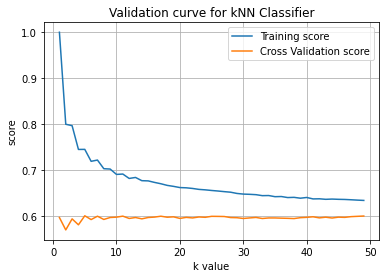

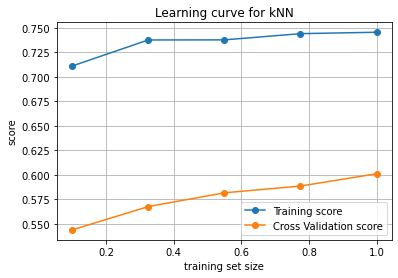

In [36]:
for k in range(1, 20):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    prediction_y = knn_classifier.predict(X_test)
    knn_classifier_accuracy = accuracy_score(y_test, prediction_y)
    print('Accuracy of KNN Classifier with k value = %d is %.2f%%' % (k, knn_classifier_accuracy * 100))

train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors",
                                             param_range= np.arange(1, 50), cv=5)

mean_train_scores = np.mean(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
plt.figure()
plt.title('Validation curve for kNN Classifier')
plt.plot(np.arange(1, 50), mean_train_scores, label='Training score')
plt.plot(np.arange(1, 50), mean_test_scores, label='Cross Validation score')
plt.xlabel('k value')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'knn_validation_curve_1.png')


optimal_k = np.argmax(np.mean(test_scores, axis=1)) + 1
print('Optimal value of k: %d' % optimal_k)
best_knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k)
best_knn_classifier.fit(X_train, y_train)
prediction_y = best_knn_classifier.predict(X_test)
accuracy_score = accuracy_score(y_test, prediction_y)
print('Accuracy of kNN with k = %d is %.2f%%' % (optimal_k, accuracy_score * 100))


_, train_scores, test_scores = learning_curve(best_knn_classifier, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5)
mean_train_scores = np.mean(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)

plt.figure()
plt.title('Learning curve for kNN')
plt.plot(np.linspace(0.1, 1.0, 5), mean_train_scores, 'o-', label='Training score')
plt.plot(np.linspace(0.1, 1.0, 5), mean_test_scores, 'o-', label='Cross Validation score')
plt.xlabel('training set size')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(img_path + 'knn_learning_curve.png')

